# This is the first script that needs to be run on Google Colab

# Before you get started:
1. Click on "Runtime" then "Change runtime Type"
2. Change hardware accelerator to "GPU"

## We need to install some things on the server

In [ ]:
!pip install PyDrive

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile, os
import warnings
warnings.filterwarnings('ignore')

class download_data_from_folder(object):
    def __init__(self,path):
        path_id = path[path.find('id=')+3:]
        self.file_list = self.get_files_in_location(path_id)
        self.unwrap_data(self.file_list)
    def get_files_in_location(self,folder_id):
        file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
        return file_list
    def unwrap_data(self,file_list,directory='.'):
        for i, file in enumerate(file_list):
            print(str((i + 1) / len(file_list) * 100) + '% done copying')
            if file['mimeType'].find('folder') != -1:
                if not os.path.exists(os.path.join(directory, file['title'])):
                    os.makedirs(os.path.join(directory, file['title']))
                print('Copying folder ' + os.path.join(directory, file['title']))
                self.unwrap_data(self.get_files_in_location(file['id']), os.path.join(directory, file['title']))
            else:
                if not os.path.exists(os.path.join(directory, file['title'])):
                    downloaded = drive.CreateFile({'id': file['id']})
                    downloaded.GetContentFile(os.path.join(directory, file['title']))
        return None
def unzip(path_to_zip, out_path):
  with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
      zip_ref.extractall(out_path)
  return None

## Now, since we're logged into the server, we need to log in to our google account so it can download files

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## This will download the data and unzip it to the server
## Do not worry, this will not affect your space on your google drive

In [ ]:
data_path = 'https://drive.google.com/open?id=1fY6B4Q7L2viZmr8cAWl0wCBUeaN0UO1E'
download_data_from_folder(data_path)
path_to_data = os.path.join('.','Data.zip')
out_path = os.path.join('.')
print('Unzipping!')
unzip(path_to_data,out_path)

In [ ]:
!git clone --recurse-submodules -j8 https://github.com/brianmanderson/Imaging_Physics_Workshop_1_28_20.git
os.chdir(os.path.join('.','Imaging_Physics_Workshop_1_28_20'))
!pip install 'tensorflow-gpu==1.15.0'
!pip install pydicom
!pip install SimpleITK

### Finished!

# DeepBox

## First we need to import a few things, this includes our generator and visualizing module

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
sys.path.append('..')
from Base_Deeplearning_Code.Visualizing_Model.Visualing_Model import visualization_model_class
%matplotlib inline

Using TensorFlow backend.


## What do we need? We need a way to generate larges amounts of training data for our model..

In [2]:
from Shape_Maker import Data_Generator, make_rectangle, make_circle
image_size = 64

## The make_rectangle and make_circle will both return circles and rectangles, and the Data_Generator will randomly create circles or rectangles

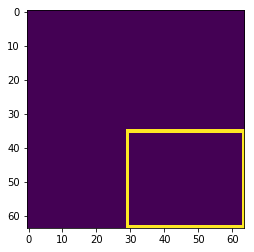

In [3]:
plt.imshow(make_rectangle(image_size))

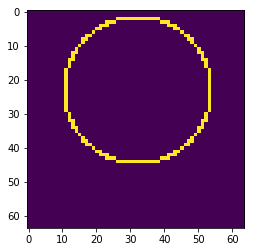

In [4]:
plt.imshow(make_circle(image_size))

### Our generator essentially continiously creates examples

In [5]:
train_generator = Data_Generator(image_size=image_size,batch_size=32, num_examples_per_epoch=150)

In [6]:
x,y = train_generator.__getitem__(0)
print(x.shape)
print(y.shape)

(32, 64, 64, 1)
(32, 2)


## Now lets make our network!

In [7]:
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Activation
from keras.optimizers import Adam
import tensorflow as tf
import keras.backend as K
from tensorflow import Graph, Session, ConfigProto, GPUOptions

### This will make sure multiple networks don't clog up the GPU

In [8]:
def prep_network():
    K.clear_session()
    gpu_options = tf.GPUOptions(allow_growth=True)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=False))
    K.set_session(sess)
    return None

### Representation of network

![DeepBox_Network.png](./DeepBox_Network.png)

### Building the network

In [9]:
prep_network()
num_kernels = 4
kernel_size = (3,3)
model = Sequential([
    Conv2D(num_kernels, kernel_size, 
           input_shape=(image_size, image_size, 1), 
           padding='same',name='Conv_0',activation='sigmoid'),
    MaxPool2D((image_size)), # Pool into a 1x1x4 image
    Flatten(),
    Dense(2,activation='softmax')
])

W0129 11:22:34.718690  1236 deprecation_wrapper.py:119] From C:\Users\bmanderson\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0129 11:22:34.719722  1236 deprecation_wrapper.py:119] From C:\Users\bmanderson\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0129 11:22:34.731730  1236 deprecation_wrapper.py:119] From C:\Users\bmanderson\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0129 11:22:34.739744  1236 deprecation_wrapper.py:119] From C:\Users\bmanderson\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placehold

### Defining loss
#### We are specifying that we care about the categorical cross entropy, with a learning rate of 0.1 (very high)

In [10]:
model.compile(Adam(lr=1e-1), loss='categorical_crossentropy', metrics=['accuracy'])

W0129 11:22:34.784692  1236 deprecation_wrapper.py:119] From C:\Users\bmanderson\AppData\Roaming\Python\Python36\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



### Train
#### We give the model our generator, and tell it to run for 5 epochs

In [11]:
model.fit_generator(train_generator,epochs=5)

W0129 11:22:34.858917  1236 deprecation.py:323] From c:\users\bmanderson\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
150/150 [==============================] - 2s 12ms/step - loss: 0.1825 - acc: 0.9454
Epoch 2/5
150/150 [==============================] - 2s 13ms/step - loss: 0.0056 - acc: 1.0000
Epoch 3/5
150/150 [==============================] - 2s 11ms/step - loss: 0.0022 - acc: 1.0000
Epoch 4/5
150/150 [==============================] - 2s 12ms/step - loss: 0.0012 - acc: 1.0000
Epoch 5/5
150/150 [==============================] - 2s 13ms/step - loss: 7.3924e-04 - acc: 1.0000


### Evaluate
### We will randomly create 500 examples of rectangles and circles and see how well our model does

In [12]:
def determine_accuracy(model, image_size= 64, num_examples=1000):
    truth = np.zeros((num_examples,1))
    guess = np.zeros((num_examples,1))
    index = 0
    for _ in range(num_examples//2):
        pred = model.predict(make_rectangle(image_size)[None,...,None])
        guess[index] = np.argmax(pred)
        truth[index] = 1
        index += 1
    for _ in range(num_examples//2):
        pred = model.predict(make_circle(image_size)[None,...,None])
        guess[index] = np.argmax(pred)
        index += 1
    print('Accuracy is {} for {} examples'.format(str((guess==truth).sum()/num_examples),num_examples))

In [13]:
determine_accuracy(model)

Accuracy is 1.0 for 1000 examples


### Lets see how confident it is in it's predictions, generate a random circle or rectangle and see what the confidence is

In [14]:
rectangle = make_rectangle(image_size)[None,...,None]
circle = make_circle(image_size)[None,...,None]
print('{}% confident'.format(model.predict(rectangle)[...,1][0]*100))
print('{}% confident'.format(model.predict(circle)[...,0][0]*100))

99.93651509284973% confident
99.97038245201111% confident


## Lets see what the kernels and activations look like

In [15]:
Visualizing_Class = visualization_model_class(model=model)

Conv_0
max_pooling2d_1
flatten_1
dense_1


### Say that we only want to look at Conv_0

In [16]:
Visualizing_Class.define_desired_layers(desired_layer_names=['Conv_0'])

## Kernels

Conv_0


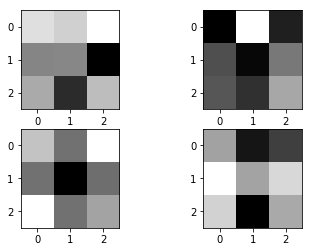

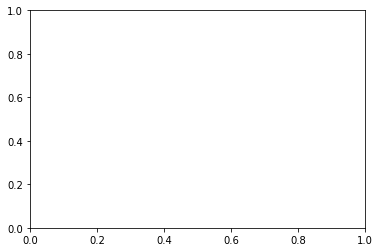

In [17]:
Visualizing_Class.plot_kernels()

## Activations
### In order to make an activation map we need to provide it with something to predict on

In [18]:
Visualizing_Class.predict_on_tensor(make_rectangle(image_size)[None,...,None])

['Conv_0']
Conv_0
0.0


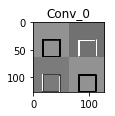

In [19]:
Visualizing_Class.plot_activations()

## How big is this model? Super tiny!!

In [42]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_0 (Conv2D)              (None, 64, 64, 4)         40        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 4)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 10        
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________


# Data curation

### Import some necessary functions

In [1]:
import os
def return_sys_path():
    path = '.'
    for _ in range(5):
        if 'Pre_Processing' in os.listdir(path):
            break
        else:
            path = os.path.join(path,'..')
    return path

In [2]:
import pydicom, sys
sys.path.append(return_sys_path())
import numpy as np
import SimpleITK as sitk
from Pre_Processing.Distribute_Patients import Separate_files
from Pre_Processing.Dicom_RT_and_Images_to_Mask.Image_Array_And_Mask_From_Dicom_RT import Dicom_to_Imagestack
from Pre_Processing.Dicom_RT_and_Images_to_Mask.Plot_And_Scroll_Images.Plot_Scroll_Images import plot_Image_Scroll_Bar_Image
from Pre_Processing.Make_Single_Images.Make_Single_Images_Class import run_main

## Finding the Data

### Find where we put our data

In [3]:
data_path = os.path.join(return_sys_path(),'Data','Whole_Patients')
print('We have ' + str(len(os.listdir(data_path))) + ' patients!')

We have 20 patients!


## Ensuring contour fidelity...

### Note that we've set 'get_images_mask' to False, this means we won't be getting any of the image data, just looking at the dicom RT files

In [4]:
Dicom_Reader = Dicom_to_Imagestack(get_images_mask=False)

In [5]:
Dicom_Reader.down_folder(data_path)

### What ROI names do we have?

#### This will tell us all the unique roi names, hence all_rois

In [6]:
for roi in Dicom_Reader.all_rois:
    print(roi)

bma_liver
Liver_BMA_Program_4
tried_liver
best_liver
Liver


## Make contour associations

#### We have quite a few contour names here.. now, we can either change the ROI names in the RT files, or make an associations file

#### The associations file associates a contour name with another one {'Current contour':'Desired name'}

In [7]:
associations = {'Liver_BMA_Program_4':'Liver',
                'bma_liver':'Liver',
                'best_liver':'Liver',
                'tried_liver':'Liver'}

### Tell the Dicom_Reader that we want to set the associations, get the images and mask for contour 'Liver'

In [8]:
Dicom_Reader.set_associations(associations)
Dicom_Reader.set_get_images_and_mask(True)
Dicom_Reader.set_contour_names(['liver'])

### Re-write RTs
#### This is commented out, because if I run it, then the example above won't show any different contour names

In [9]:
# Dicom_Reader.associations = associations
# for RT in Dicom_Reader.all_RTs:
#     Dicom_Reader.rewrite_RT(RT)

## Pulling images and mask

### We'll first do this with one patient

In [10]:
patient_data_path = os.path.join(data_path,'ABD_LYMPH_036')
Dicom_Reader.Make_Contour_From_directory(patient_data_path)
print('Done!')

Done!


## View images

In [11]:
%matplotlib inline

### The images and mask are saved within the Dicom_Reader class, so we just have to load them

In [12]:
Images = Dicom_Reader.ArrayDicom
mask = Dicom_Reader.mask # This is the mask

#### Threshold

In [13]:
Images[Images<-200] = -200
Images[Images>200] = 200

In [16]:
plot_Image_Scroll_Bar_Image(Images)

interactive(children=(IntSlider(value=0, description='Z', max=160), Text(value='2D', description='view'), Outp…

In [15]:
Images[mask==1] += 300

## Recap

### Checking ROI contour names and making associations

### Loading in image and mask from desired contour name

### Viewing images and mask

## Separate into Train/Test/Validation

### This is also important, but I would recommend using the 'Parallel' approach available in https://github.com/brianmanderson/Dicom_Data_to_Numpy_Arrays
### For ease, this has already been done for you

In [17]:
def write_data(data_path, out_path, Dicom_Reader,desc = 'TCIA_Liver_Patients'):
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    print(out_path)
    Dicom_Reader.set_description(desc)
    iteration = 0
    for patient in os.listdir(data_path):
        print(patient)
        patient_data_path = os.path.join(data_path,patient)
        out_file = os.path.join(patient_data_path, desc + '_Iteration_' + str(iteration) + '.txt')
        if not os.path.exists(out_file):
            Dicom_Reader.Make_Contour_From_directory(patient_data_path)
            Dicom_Reader.set_iteration(iteration)
            Dicom_Reader.write_images_annotations(out_path)
        iteration += 1
    return None

In [18]:
output_path = data_path.replace('Whole_Patients','Niftii_Arrays')
#write_data(data_path,output_path, Dicom_Reader)
#Separate_files(output_path) # Separate into a Training/Validation/Test set
#run_main(output_path,extension=5)

# Liver Model

## Import some things

In [1]:
import os
def return_sys_path():
    path = '.'
    for _ in range(5):
        if 'Deep_Learning' in os.listdir(path):
            break
        else:
            path = os.path.join(path,'..')
    return path

In [2]:
import os, sys
sys.path.append(return_sys_path())
from Deep_Learning.Base_Deeplearning_Code.Data_Generators.Generators import Data_Generator_Class, os
from Deep_Learning.Base_Deeplearning_Code.Keras_Utils.Keras_Utilities import np, dice_coef_3D
from Deep_Learning.Base_Deeplearning_Code.Data_Generators.Image_Processors import *
from Deep_Learning.Base_Deeplearning_Code.Callbacks.Visualizing_Model_Utils import TensorBoardImage
# from Utils import ModelCheckpoint, model_path_maker
from Deep_Learning.Base_Deeplearning_Code.Plot_And_Scroll_Images.Plot_Scroll_Images import plot_Image_Scroll_Bar_Image
import tensorflow as tf
import tensorflow.python.keras.backend as K

W0217 17:43:22.398360 17780 deprecation.py:506] From c:\users\bmanderson\appdata\local\programs\python\python36\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [3]:
%matplotlib inline

In [4]:
%load_ext tensorboard

In [5]:
base = return_sys_path()
data_path = os.path.join(base,'Data','Niftii_Arrays')
train_path = [os.path.join(data_path,'Train')]
validation_path = os.path.join(data_path,'Validation')
test_path = os.path.join(data_path,'Test')
model_path = os.path.join(base,'Models')
if not os.path.exists(model_path):
    os.makedirs(model_path)

## We now need some image processors...

#### We will ensure that the images are 256 x 256 (downsampled for speed), normalize them with a mean of 78 and std of 29, add random noise, threshold, and turn into 2 classes

In [6]:
image_size = 128
image_processors_train = [Ensure_Image_Proportions(image_size,image_size),Repeat_Channel(repeats=3),
                          Normalize_Images(mean_val=78,std_val=29),
                          Threshold_Images(lower_bound=-3.55,upper_bound=3.55, post_load=False),
                          Annotations_To_Categorical(2)]
#Add_Noise_To_Images(variation=np.round(np.arange(start=0, stop=0.3, step=0.1),2)),
image_processors_test = [Ensure_Image_Proportions(image_size,image_size),Normalize_Images(mean_val=78,std_val=29),
                         Repeat_Channel(repeats=3), Threshold_Images(lower_bound=-3.55,upper_bound=3.55),
                         Annotations_To_Categorical(2)]

In [7]:
batch_size = 5
train_generator = Data_Generator_Class(by_patient=False,shuffle=True,data_paths=train_path,batch_size=batch_size,
                                       image_processors=image_processors_train)
validation_generator = Data_Generator_Class(by_patient=True,shuffle=True,data_paths=validation_path,batch_size=30,
                                            image_processors=image_processors_test, by_patient_2D=True)

### Lets visualize one of the examples! With batch_size of 5 and shuffle on, it will be 5 random 2D slices

In [8]:
x,y = train_generator.__getitem__(0)

In [9]:
plot_Image_Scroll_Bar_Image(x)

interactive(children=(IntSlider(value=0, description='Z', max=4), Text(value='2D', description='view'), Output…

### Alright, lets make our model!

In [ ]:
from Deep_Learning.Easy_VGG16_UNet.Keras_Fine_Tune_VGG_16_Liver import VGG_16
from Deep_Learning.Base_Deeplearning_Code.Visualizing_Model.Visualing_Model import visualization_model_class
from tensorflow.python.keras.optimizers import Adam

### This is just a click and play, it builds the VGG16 architecture for you with pre-trained weights

![VGG16_Unet.png](./Deep_Learning/Easy_VGG16_UNet/VGG16_UNet.png)

In [ ]:
K.clear_session()
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=False))
K.set_session(sess)
network = {'Layer_0': {'Encoding': [64, 64], 'Decoding': [64]},
           'Layer_1': {'Encoding': [128, 128], 'Decoding': [64]},
           'Layer_2': {'Encoding': [256, 256, 256], 'Decoding': [256]},
           'Layer_3': {'Encoding': [512, 512, 512], 'Decoding': [256]},
           'Layer_4': {'Encoding': [512, 512, 512]}}
VGG_model = VGG_16(network=network, activation='relu',filter_size=(3,3))
VGG_model.make_model()
VGG_model.load_weights()
new_model = VGG_model.created_model
model_path = os.path.join(return_sys_path(),'Models')

## These are some tools for visualizing the model

In [ ]:
Visualizing_Class = visualization_model_class(model=new_model, save_images=True, verbose=True)

### Lets look at the activations of block1_conv1, the activation, and output

In [ ]:
Visualizing_Class.define_desired_layers(['block1_conv1','block1_conv1_activation','Output'])

In [ ]:
Visualizing_Class.predict_on_tensor(x[0,...][None,...])

In [ ]:
Visualizing_Class.plot_activations()

In [ ]:
new_model.compile(Adam(lr=5e-5),loss='categorical_crossentropy', metrics=['accuracy',dice_coef_3D])

## Freezing pre-trained layers

In [ ]:
def freeze_until_name(model,name):
    set_trainable = False
    for layer in model.layers:
        if layer.name == name:
            set_trainable = True
        layer.trainable = set_trainable
    return model
new_model = freeze_until_name(new_model,'Upsampling0_UNet')

## Checkpoint and run

A checkpoint is a way of assessing the model and determining if we should save it

In [ ]:
model_name = 'VGG_16_Model'
other_aspects = [model_name,'Upsampling0_UNet_Unfrozen'] # Just a list of defining things
model_path_out = model_path_maker(model_path,other_aspects)

In [ ]:
checkpoint = ModelCheckpoint(os.path.join(model_path_out,'best-model.hdf5'), monitor='val_dice_coef_3D', verbose=1, save_best_only=True,
                              save_weights_only=False, period=5, mode='max')
# TensorboardImage lets us view the predictions of our model
tensorboard = TensorBoardImage(log_dir=model_path_out, batch_size=1, num_images=3,update_freq='epoch', 
                               data_generator=validation_generator)
callbacks = [checkpoint, tensorboard]

In [ ]:
%tensorboard --logdir {"../Models"}

In [ ]:
new_model.fit_generator(train_generator,epochs=1, workers=20, max_queue_size=50, validation_data=validation_generator,callbacks=callbacks)

In [ ]:
x,y = validation_generator.__getitem__(0)

In [ ]:
pred = new_model.predict(x)

In [ ]:
pred[pred<0.5] = 0
pred[pred>0] = 1

In [ ]:
plot_scroll_Image(pred[...,1])

# Now lets make our own architecture

### First, lets import some necessary functions

In [10]:
from Deep_Learning.Base_Deeplearning_Code.Models.Keras_3D_Models import my_3D_UNet
from Deep_Learning.Base_Deeplearning_Code.Cyclical_Learning_Rate.clr_callback import CyclicLR
from tensorflow.python.keras.callbacks import ModelCheckpoint
from functools import partial
from tensorflow.python.keras.optimizers import Adam

### Define our convolution and strided blocks, strided is used for downsampling

In [11]:
activation = 'relu'
kernel = (3,3)
pool_size = (2,2)
#{'channels': x, 'kernel': (3, 3), 'strides': (1, 1),'activation':activation}
conv_block = lambda x: {'channels': x}
strided_block = lambda x: {'channels': x, 'strides': (2, 2)}

### Our architecture will have 2 main parts in each layer, an 'Encoding' and a 'Decoding' side, 'Encoding' goes down, and 'Decoding' goes up

![Encoding and Decoding.png](./Deep_Learning/Encoding_and_Decoding.png)

### We will now create our layer dictionary, this tells our UNet what to look like

### If Pooling is left {} it will perform maxpooling and upsampling with pooling()

In [14]:
layers_dict = {}
filters = 16
layers_dict['Layer_0'] = {'Encoding':[conv_block(filters),conv_block(filters)],
                          'Decoding':[conv_block(filters),conv_block(filters)],
                          'Pooling':{}}
filters = 32
layers_dict['Base'] = {'Encoding':[conv_block(filters), conv_block(filters),conv_block(filters)]}

In [15]:
layers_dict

{'Layer_0': {'Encoding': [{'channels': 16}, {'channels': 16}],
  'Decoding': [{'channels': 16}, {'channels': 16}],
  'Pooling': {}},
 'Base': {'Encoding': [{'channels': 32}, {'channels': 32}, {'channels': 32}]}}

In [16]:
K.clear_session()
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=False))
K.set_session(sess)
new_model = my_3D_UNet(kernel=kernel,layers_dict=layers_dict, pool_size=pool_size,activation=activation,is_2D=True,
                       input_size=3, image_size=image_size).created_model

Layer_0
Base
Layer_0


### Set a learning rate and loss metric, also add any metrics you want to track

In [17]:
min_lr = 5e-6
max_lr = 8e-4
new_model.compile(Adam(lr=min_lr),loss='categorical_crossentropy', metrics=['accuracy',dice_coef_3D])

### Name your model and define other things! Send a list of strings and it will make a folder path

In [18]:
model_name = 'My_New_Model'
other_aspects = [model_name,'{}_Layers'.format(3),'{}_Conv_Blocks'.format(2),
                 '{}_Filters'.format(16),'{}_MinLR_{}_MaxLR'.format(min_lr,max_lr)] # Just a list of defining things
model_path_out = model_path_maker(model_path,other_aspects)

NameError: name 'model_path_maker' is not defined

### A few more parameters...

In [19]:
steps_per_epoch = len(train_generator)//3
step_size_factor = 2

### This is a checkpoint to save the model if it has the highest dice, also to add images

#### We will specify that we want to watch the validation dice, and save the one with the highest value

In [29]:
monitor = 'val_dice_coef_3D'
mode = 'max'
checkpoint = ModelCheckpoint(os.path.join(model_path_out,'best-model.hdf5'), monitor=monitor, verbose=1, save_best_only=True,
                             save_weights_only=False, period=5, mode=mode)

#### Next, our tensorboard output will add prediction images

In [23]:
# TensorboardImage lets us view the predictions of our model
tensorboard = TensorBoardImage(log_dir=os.path.join('.','Models'), batch_size=1, num_images=1,update_freq='epoch', 
                               data_generator=validation_generator, image_frequency=3)


W0217 17:45:50.838107 17780 Visualizing_Model_Utils.py:520] `batch_size` is no longer needed in the `TensorBoard` Callback and will be ignored in TensorFlow 2.0.


#### CyclicLR will allow us to change the learning rate of the model as it runs, and Add_LR_To_Tensorboard will let us view it later

In [ ]:
cyclic_lrate = CyclicLR(base_lr=min_lr, max_lr=max_lr, step_size=steps_per_epoch * step_size_factor, mode='triangular2')
add_lr_to_tensorboard = Add_LR_To_Tensorboard()

### Combine all callbacks

In [ ]:
callbacks = [cyclic_lrate, add_lr_to_tensorboard, tensorboard, checkpoint]

In [24]:
new_model.fit_generator(train_generator,epochs=10, workers=50, max_queue_size=200, validation_data=validation_generator,
                       callbacks=callbacks, steps_per_epoch=steps_per_epoch)

Epoch 1/10


W0217 17:46:03.330332 17780 deprecation.py:323] From c:\users\bmanderson\appdata\local\programs\python\python36\lib\site-packages\tensorflow_core\python\ops\math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


279/279 [==============================] - 124s 444ms/step - loss: 0.6445 - acc: 0.6844 - dice_coef_3D: 0.1133 - val_loss: 0.5456 - val_acc: 0.9282 - val_dice_coef_3D: 0.1011
Epoch 2/10
279/279 [==============================] - 91s 327ms/step - loss: 0.4490 - acc: 0.9249 - dice_coef_3D: 0.1297 - val_loss: 0.3606 - val_acc: 0.9016 - val_dice_coef_3D: 0.1957
Epoch 3/10
279/279 [==============================] - 82s 295ms/step - loss: 0.2384 - acc: 0.9347 - dice_coef_3D: 0.1845 - val_loss: 0.1918 - val_acc: 0.9103 - val_dice_coef_3D: 0.2922
Epoch 4/10
279/279 [==============================] - 77s 277ms/step - loss: 0.1460 - acc: 0.9384 - dice_coef_3D: 0.2452 - val_loss: 0.1757 - val_acc: 0.8943 - val_dice_coef_3D: 0.3434
Epoch 5/10
279/279 [==============================] - 76s 273ms/step - loss: 0.1266 - acc: 0.9365 - dice_coef_3D: 0.2937 - val_loss: 0.1456 - val_acc: 0.9151 - val_dice_coef_3D: 0.3360
Epoch 6/10
279/279 [==============================] - 78s 278ms/step - loss: 0.1166 -

In [ ]:
%tensorboard --logdir {"./Models"}